In [28]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import fitsio
from fitsio import FITS, FITSHDR
import datetime
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import time

In [29]:
from some_func import cart2spheric, spheric2cart, spheric_coordinates_rotate, hor2pix_s1c, bright_relay_s1c

In [30]:
img_num=500
# img_num=3351

In [31]:
pic_save_name='/home/ashindin/temp/' + "{0:0>3}".format(img_num) + '.png'

In [32]:
fit_filename='/mnt/Work_disk/Owncloud/0000_Two_points/DATA/01_S1C/140826/aug26red15bin2_0' + "{0:0>3}".format(img_num) + '.fit'
dark_filename='/mnt/Work_disk/Owncloud/0000_Two_points/DATA/01_S1C/140826/dark/s1c_aug26_dark_median.fit'
BS6300_catalog_filename='Haritonov_6300BS_catalog.npz'

In [33]:
# Координаты расположения S1C
lat_s1c=56.1501667 # ШИРОТА
lon_s1c=46.1050833 # ДОЛГОТА
h_s1c=183.0
S1C_site=EarthLocation(lat=lat_s1c*u.deg, lon=lon_s1c*u.deg, height=h_s1c*u.m)

# Ориентация S1C - 26 августа
az0_s1c = 3.273747186726014;
alt0_s1c = 1.5470500778432814;
a_s1c = (0.17638446258114976, -0.0012472703206068809, -5.316537749985197e-5)
b_s1c = (0.19928459764658202, 5.100993511668623e-5, -0.0012452931691676276)
c_s1c = (134.36032720169513, -800.3341162043586, 34.16915787711284)
d_s1c = ( 165.53392397449926, -32.78284210934066, -801.5998710431686)

In [34]:
npzfile=np.load(BS6300_catalog_filename)
CAT_FIELDS=npzfile['CAT_FIELDS']
CAT_6300BS=npzfile['CAT_6300BS']
CAT_SPTYPE=npzfile['CAT_SPTYPE']
print(CAT_FIELDS)

['HARITONOV_ID' 'BS_ID' 'RA (icrs, deg)' 'DEC (icrs, deg)' 'MAG_V'
 '6300 Flux (erg/(sm^2 * s *  sm))']


In [35]:
fitfile=fitsio.FITS(fit_filename)
img=fitfile[0].read()
dark=fitsio.read(dark_filename)
img=img.astype('d')-dark.astype('d')
header=fitfile[0].read_header()
fitfile.close()
date_obs_str=header['COMMENT'][7:31]
if date_obs_str[16]==' ':
    date_obs_str=date_obs_str[0:16] + '0' + date_obs_str[17:24]
if date_obs_str[17]==' ':
    date_obs_str=date_obs_str[0:17] + '0' + date_obs_str[18:24]
date_obs=datetime.datetime.strptime(date_obs_str,"%b %d %H:%M:%S.%f %Y") - datetime.timedelta(seconds=7.5) - datetime.timedelta(hours=4)
print(date_obs)

2014-08-26 20:16:41.876000


In [36]:
BS_coord=SkyCoord(CAT_6300BS[:,2], CAT_6300BS[:,3], frame='icrs', unit='deg');

altaz=BS_coord.transform_to(AltAz(obstime=date_obs, location=S1C_site,temperature=15*u.deg_C,pressure=1013*u.hPa,
                                       relative_humidity=0.5,obswl=630.0*u.nm))
BS_AzAlt=np.zeros((np.size(CAT_6300BS,0),2))
BS_AzAlt[:,0]=altaz.az.degree
BS_AzAlt[:,1]=altaz.alt.degree

In [37]:
BS_xy=np.zeros((np.size(CAT_6300BS,0),2))
BS_xy[:,0], BS_xy[:,1] = hor2pix_s1c (BS_AzAlt[:,0]*np.pi/180,BS_AzAlt[:,1]*np.pi/180, az0_s1c, alt0_s1c, c_s1c, d_s1c)

In [38]:
# Catalog filtration
filt_mask=np.zeros(np.size(CAT_6300BS,0),dtype=bool)
for i in range(0,np.size(CAT_6300BS,0)):
    if BS_AzAlt[i,1]>=85.0:
        if BS_xy[i,0]>=1 and BS_xy[i,0]<=288:
            if BS_xy[i,1]>=1 and BS_xy[i,1]<=288:
                filt_mask[i]=True
BS_AzAlt_filt=BS_AzAlt[filt_mask,:]
BS_xy_filt=BS_xy[filt_mask,:]
CAT_6300BS_filt=CAT_6300BS[filt_mask,:]
CAT_SPTYPE_filt=CAT_SPTYPE[filt_mask]

In [39]:
np.size(BS_xy_filt,0)

2

In [40]:
CAT_6300BS_filt[:,0]

array([ 494.,  512.])

In [41]:
np.median(img)

224.0

In [42]:
int(BS_xy_filt[:,0][0]),int(BS_xy_filt[:,1][0])

(119, 213)

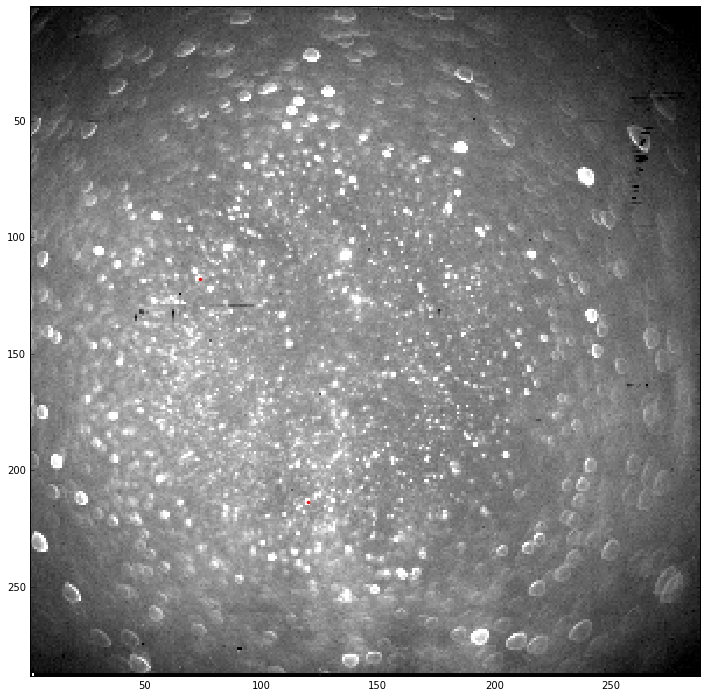

In [43]:
area_rad=4

fig=plt.figure(figsize=(12,12))
ax = plt.subplot(111)
# plt.imshow(img, cmap="gray", vmin=300, vmax=900)
plt.pcolormesh(img, cmap="gray", vmin=np.median(img)-100, vmax=np.median(img)+100)

plt.plot(BS_xy_filt[:,0],BS_xy_filt[:,1],color="r",marker=".", lw=0.,mec="r", mfc="r")

# ax.set_xlim([166-area_rad,166+area_rad]);
# ax.set_ylim([189+area_rad,189-area_rad]);

# ax.set_xlim([166-10,166+10]);
# ax.set_ylim([189+10,189-10]);


ax.set_xlim((1,288))
ax.set_ylim((288,1))
# plt.colorbar
plt.show()

In [44]:
img_red_st_int=np.zeros(np.size(BS_xy_filt,0))
img_red_st_num=np.zeros(np.size(BS_xy_filt,0))
BS_adc_filt=np.zeros(np.size(BS_xy_filt,0))
# area_rad=3
for j in range(np.size(BS_xy_filt,0)):    
    st_x=BS_xy_filt[j,0]
    st_y=BS_xy_filt[j,1]
    area=img[int(st_y)-area_rad:int(st_y)+area_rad+1, int(st_x)-area_rad:int(st_x)+area_rad+1]

    sum_temp=0.0
    num=0
    med=np.median(area)
    for i in range(len(area.flat)):
        if area.flat[i]>=1.3*med:
            num+=1
            sum_temp+=area.flat[i]-med
    img_red_st_int[j]=sum_temp
    img_red_st_num[j]=num
    if num>0:
        BS_adc_filt[j]=sum_temp/num

In [45]:
med

255.0

In [46]:
print(BS_adc_filt[:])

[ 353.22222222  570.33333333]


In [47]:
print(img_red_st_num)

[  9.  12.]


In [48]:
print(area)

[[  239.   256.   337.   292.   255.   246.   243.   248.   243.]
 [  240.   292.   741.   889.   267.   256.   277.   248.   254.]
 [  243.   257.   358.   392.   255.   247.   246.   249.   261.]
 [  239.   241.   246.   272.   389.   288.   274.   250.   254.]
 [  240.   239.   259.   531.  2454.  1297.   272.   273.   257.]
 [  240.   236.   247.   360.  1101.  1055.   263.   242.   243.]
 [  242.   233.   238.   279.   255.   268.   249.   237.   235.]
 [  253.   242.   240.   251.   276.   260.   264.   252.   254.]
 [  266.   249.   262.   261.   252.   255.   253.   252.   321.]]


In [49]:
BS_relay=np.zeros(np.size(BS_xy_filt,0))
R_adc_coef=np.zeros(np.size(BS_xy_filt,0))
for i in range(np.size(BS_xy_filt,0)):
     if img_red_st_num[i]>3:
            BS_relay[i]=bright_relay_s1c(CAT_6300BS_filt[i,5],img_red_st_num[i])
            if BS_adc_filt[i]>0 and BS_relay[i]>100:
                R_adc_coef[i]=BS_relay[i]/BS_adc_filt[i]

In [50]:
print(BS_relay)

[  828.81511864  1145.57089667]


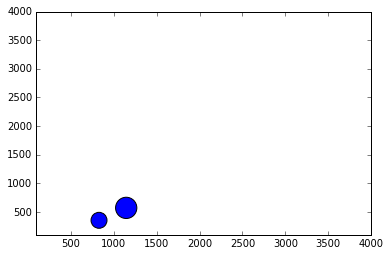

In [51]:
fig,ax = plt.subplots()
plt.scatter(BS_relay,BS_adc_filt,s=np.pi*(img_red_st_num)**2)
ax.set_xlim((100, 4000))
ax.set_ylim((100, 4000))
plt.show()

In [52]:
print(R_adc_coef[R_adc_coef.nonzero()])
R_median=np.median(R_adc_coef[R_adc_coef.nonzero()])
print(R_median)

[ 2.34644104  2.00859888]
2.17751996211


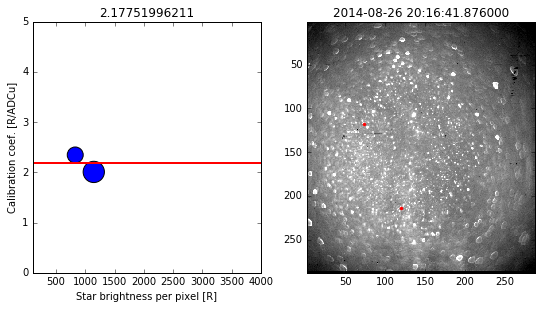

In [65]:
fig=plt.figure(figsize=(9,4.5))
ax = plt.subplot(121)
plt.plot([0, 5000], [R_median, R_median], c='r', lw=2)
plt.scatter(BS_relay,R_adc_coef,s=np.pi*(img_red_st_num)**2)
plt.ylabel('Calibration coef. [R/ADCu]')
plt.xlabel('Star brightness per pixel [R]')

plt.title(R_median)
ax.set_xlim((100, 4000))
ax.set_ylim((0, 5))

ax2=plt.subplot(122)

plt.pcolormesh(img, cmap="gray", vmin=np.median(img)-100, vmax=np.median(img)+100)
plt.plot(BS_xy_filt[:,0],BS_xy_filt[:,1],color="r",marker=".", lw=0.,mec="r", mfc="r")

plt.title(date_obs)
ax2.set_xlim((1,288))
ax2.set_ylim((288,1))

plt.show()
# plt.savefig(pic_save_name)